Аддитивная свёртка: 10 точек
Дискриминационный метод: 10 точек
Последовательные уступки: 10 точек

Значения для аддитивной свёртки:
[[154.76343744542964, 22.839177868341565, 128.8714616070288], [1.1561853989782374, 260.41633106567303, 32.47349313036542], [80.01722844500401, 66.74660820246146, 76.92898404517676], [30.69203443685666, 136.57654285572113, 41.15720757730584], [12.538563244972458, 311.7228679458082, 5.845587093696203], [22.636084331537894, 182.76442355288708, 21.299402450670563], [206.77968044244088, 8.746120794286057, 166.16003722900984], [265.12514463247106, 1.4599573115902387, 209.06800050893054], [115.97151875677885, 40.63373989804968, 102.48535907758736], [32.98614937368172, 367.8535291056478, 0.061034859968100715]]

Значения для дискриминационного метода:
[[0.5980591430287795, 269.0678531967749, 37.205931650153275], [35.30593432689349, 374.00536496167086, 0.003156710035849211], [31.731547204471337, 130.40425566805598, 52.09801731521256], [295.9886374479055, 0.132923547

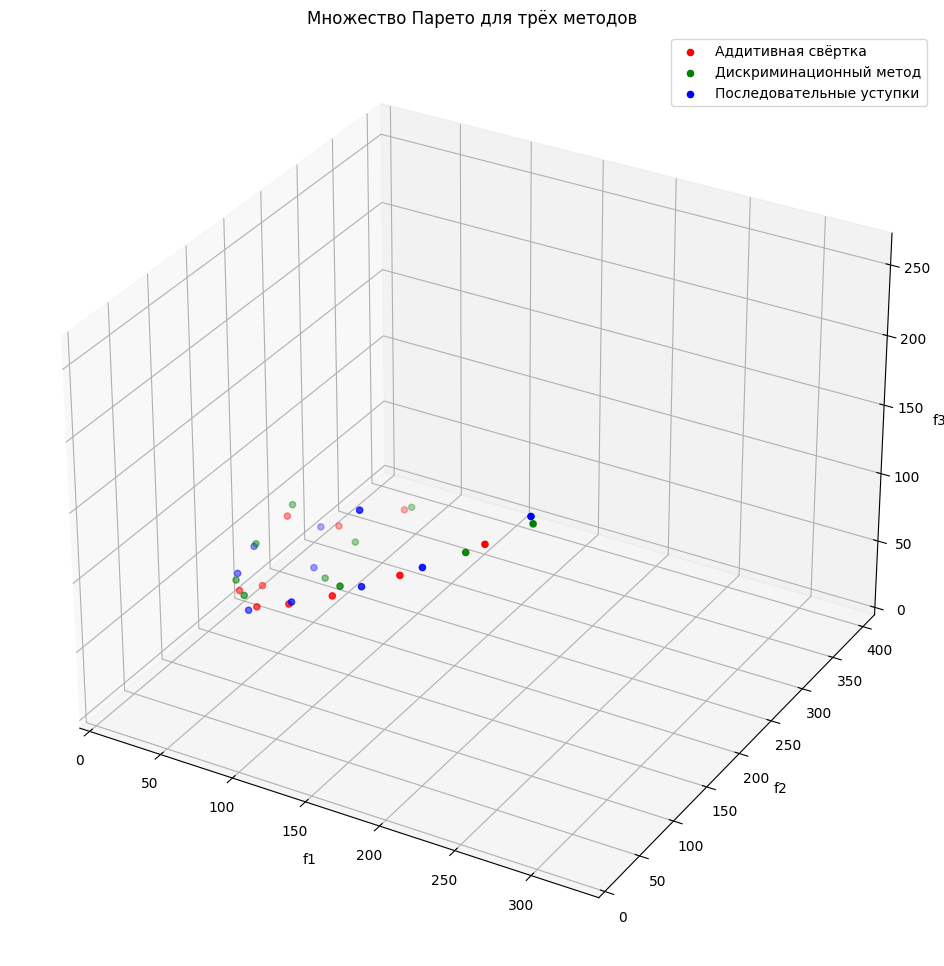

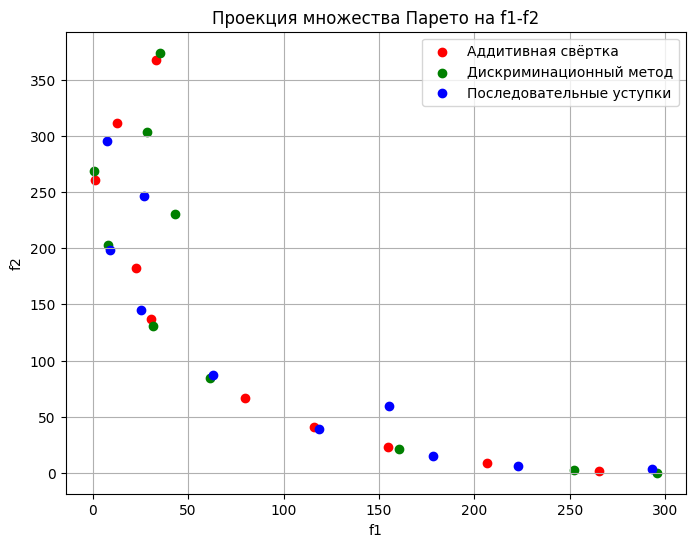

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Определение критериев эффективности
# Критерии: f_i(x_1, x_2) = a_i (x_1 - b_i)^2 + c_i (x_2 - d_i)^2
# Новые точки минимума и коэффициенты:
# - f1: минимум в (4, 5), a_1 = 1.5, c_1 = 2.5
# - f2: минимум в (-6, -3), a_2 = 2, c_2 = 1.5
# - f3: минимум в (7, 2), a_3 = 1, c_3 = 3
def f1(x):
    return 1.5 * (x[0] - 4)**2 + 2.5 * (x[1] - 5)**2

def f2(x):
    return 2 * (x[0] + 6)**2 + 1.5 * (x[1] + 3)**2

def f3(x):
    return 1 * (x[0] - 7)**2 + 3 * (x[1] - 2)**2

# Аналитические градиенты
# grad_f_i(x) = [2 a_i (x_0 - b_i), 2 c_i (x_1 - d_i)]
def grad_f1(x):
    return np.array([3 * (x[0] - 4), 5 * (x[1] - 5)])

def grad_f2(x):
    return np.array([4 * (x[0] + 6), 3 * (x[1] + 3)])

def grad_f3(x):
    return np.array([2 * (x[0] - 7), 6 * (x[1] - 2)])

# Градиент комбинированной функции (для метода аддитивной свертки)
# Используется в методе аддитивной свертки, где целевая функция — это взвешенная сумма критериев:
# f(x) = alpha_1 * f1(x) + alpha_2 * f2(x) + alpha_3 * f3(x)
def grad_combined(x, alpha):
    return alpha[0] * grad_f1(x) + alpha[1] * grad_f2(x) + alpha[2] * grad_f3(x)

# Проверка уникальности точек
# Для построения множества Парето важно, чтобы точки были достаточно разнообразны.
# Эта функция проверяет, что новая точка в пространстве критериев (f1, f2, f3)
# находится на расстоянии не менее threshold от уже существующих точек.
def is_unique(new_point, points, threshold=50.0):
    for p in points:
        if np.linalg.norm(np.array(new_point) - np.array(p)) < threshold:
            return False
    return True

# Проекция на допустимую область (для учёта ограничений)
# Используется в дискриминационном методе и методе последовательных уступок для выполнения ограничений.
# Если точка нарушает ограничение (например, f2(x) > a2), мы корректируем x в направлении,
# противоположном градиенту нарушения, используя аналитические градиенты для f2 и f3.
def project_to_constraints(x, constraints, lr=0.001, max_iter=100):
    if not constraints:
        return x
    x_new = x.copy()
    for _ in range(max_iter):
        grad_penalty = np.zeros_like(x)
        for constraint in constraints:
            val = constraint['fun'](x_new)
            if val < 0:
                if constraint.get('label') == 'f2':
                    grad_penalty -= grad_f2(x_new)
                elif constraint.get('label') == 'f3':
                    grad_penalty -= grad_f3(x_new)
                else:
                    grad_penalty -= numerical_gradient(lambda x: -constraint['fun'](x), x_new)
        x_new += lr * grad_penalty
        if np.linalg.norm(grad_penalty) < 1e-6:
            break
    return x_new

# Численное вычисление градиента
# Используется для ограничений, где аналитический градиент недоступен (например, в методе последовательных уступок).
# Численный градиент вычисляется с помощью конечных разностей.
def numerical_gradient(f, x, eps=1e-6):
    grad = np.zeros_like(x)
    for i in range(len(x)):
        x_plus = x.copy()
        x_minus = x.copy()
        x_plus[i] += eps
        x_minus[i] -= eps
        grad[i] = (f(x_plus) - f(x_minus)) / (2 * eps)
    return grad

# Градиентный спуск с импульсом и учётом ограничений
# Используется в методе аддитивной свертки для минимизации взвешенной суммы критериев.
def gradient_descent(objective, grad_func, constraints=None, x0=None, lr=0.01, momentum=0.9, max_iter=3000, tol=1e-8):
    if x0 is None:
        x0 = np.random.normal(0, 4.0, 2)
    x = x0.copy()
    velocity = np.zeros_like(x)
    for i in range(max_iter):
        lr_iter = lr / (1 + i * 0.001)  # Адаптивный шаг
        grad = grad_func(x)
        velocity = momentum * velocity - lr_iter * grad
        x_new = x + velocity
        x_new = project_to_constraints(x_new, constraints)
        x_new = np.clip(x_new, -50, 50)
        if np.linalg.norm(x_new - x) < tol:
            break
        x = x_new
    return x

# Случайный поиск для разнообразия
# Используется в дискриминационном методе и методе последовательных уступок для поиска решений,
# которые удовлетворяют ограничениям. Случайный поиск помогает избежать локальных минимумов
# и обеспечивает большее разнообразие точек на множестве Парето.
def random_search(objective, constraints=None, bounds=(-50, 50), n_iter=500):
    best_x = np.random.uniform(bounds[0], bounds[1], 2)
    best_value = objective(best_x)
    for _ in range(n_iter):
        x = best_x + np.random.normal(0, 1.0, 2)  # Направленный поиск
        x = project_to_constraints(x, constraints)
        x = np.clip(x, -50, 50)
        value = objective(x)
        if value < best_value:
            best_x = x
            best_value = value
    return best_x

# 1. Метод аддитивной свёртки
# Этот метод основан на теории многокритериальной оптимизации
# Многокритериальная задача сводится к однокритериальной путём введения обобщённого критерия:
# F^0 = alpha_1 f1(x) + alpha_2 f2(x) + alpha_3 f3(x) -> min, x in D.
# Весовые коэффициенты alpha генерируются с помощью распределения Дирихле,
# чтобы обеспечить равномерное покрытие множества Парето.
def additive_convolution(alpha, x0=None):
    def objective(x):
        return alpha[0] * f1(x) + alpha[1] * f2(x) + alpha[2] * f3(x)
    def grad_func(x):
        return grad_combined(x, alpha)
    if x0 is None:
        x0 = np.random.normal(0, 4.0, 2)
    x_opt = gradient_descent(objective, grad_func, x0=x0)
    f_values = [f1(x_opt), f2(x_opt), f3(x_opt)]
    if max(f_values) > 800:  # Фильтрация экстремальных значений
        return None, None
    return x_opt, f_values

# Генерация 10 точек для аддитивной свёртки
pareto_points_add = []
alphas = np.random.dirichlet(np.ones(3), 100)
for alpha in alphas:
    if len(pareto_points_add) >= 10:
        break
    x_opt, f_values = additive_convolution(alpha)
    if f_values is None:
        continue
    if is_unique(f_values, pareto_points_add, threshold=50.0):
        pareto_points_add.append(f_values)

# 2. Дискриминационный метод
# Этот метод основан на теории многокритериальной оптимизации
# Один критерий (например, f1) минимизируется, а на остальные (f2, f3) накладываются ограничения:
# минимизировать f1(x) при f2(x) <= a2, f3(x) <= a3.
# Значения a2, a3 (уступки) выбираются случайно в заданном диапазоне.
def discriminatory_method(a2, a3, criterion='f1', x0=None):
    def objective(x):
        if criterion == 'f1':
            return f1(x)
        elif criterion == 'f2':
            return f2(x)
        else:
            return f3(x)
    constraints = [
        {'type': 'ineq', 'fun': lambda x: a2 - f2(x), 'label': 'f2'},
        {'type': 'ineq', 'fun': lambda x: a3 - f3(x), 'label': 'f3'}
    ]
    if x0 is None:
        x0 = np.random.normal(0, 4.0, 2)
    x_opt = random_search(objective, constraints)
    f_values = [f1(x_opt), f2(x_opt), f3(x_opt)]
    if max(f_values) > 800:
        return None, None
    return x_opt, f_values

# Генерация 10 точек для дискриминационного метода
pareto_points_disc = []
a2_values = np.random.uniform(80, 400, 100)
a3_values = np.random.uniform(80, 400, 100)
criteria = np.random.choice(['f1', 'f2', 'f3'], size=100)
for a2, a3, crit in zip(a2_values, a3_values, criteria):
    if len(pareto_points_disc) >= 10:
        break
    x_opt, f_values = discriminatory_method(a2, a3, criterion=crit)
    if f_values is None:
        continue
    if is_unique(f_values, pareto_points_disc, threshold=50.0):
        pareto_points_disc.append(f_values)

# 3. Метод последовательных уступок
# Этот метод основан на теории многокритериальной оптимизации
# Критерии оптимизируются последовательно: сначала минимизируется f1,
# затем f2 с ограничением на f1, затем f3 с ограничениями на f1 и f2.
# Параметры delta1 и delta2 задают допустимые уступки.
def sequential_concessions(delta1, delta2, order=('f1', 'f2', 'f3')):
    funcs = {'f1': f1, 'f2': f2, 'f3': f3}
    grad_funcs = {'f1': grad_f1, 'f2': grad_f2, 'f3': grad_f3}
    x1 = gradient_descent(funcs[order[0]], grad_funcs[order[0]])
    f1_star = funcs[order[0]](x1)
    constraints = [{'type': 'ineq', 'fun': lambda x: delta1 - (funcs[order[0]](x) - f1_star), 'label': order[0]}]
    x2 = random_search(funcs[order[1]], constraints)
    f2_star = funcs[order[1]](x2)
    constraints.append({'type': 'ineq', 'fun': lambda x: delta2 - (funcs[order[1]](x) - f2_star), 'label': order[1]})
    x3 = random_search(funcs[order[2]], constraints)
    f_values = [f1(x3), f2(x3), f3(x3)]
    if max(f_values) > 800:
        return None, None
    return x3, f_values

# Генерация 10 точек для метода последовательных уступок
pareto_points_seq = []
delta1_values = np.random.uniform(40, 250, 100)
delta2_values = np.random.uniform(40, 250, 100)
order_options = [('f1', 'f2', 'f3'), ('f2', 'f3', 'f1'), ('f3', 'f1', 'f2')]
orders = [order_options[i] for i in np.random.choice(len(order_options), size=100)]
for delta1, delta2, order in zip(delta1_values, delta2_values, orders):
    if len(pareto_points_seq) >= 10:
        break
    x_opt, f_values = sequential_concessions(delta1, delta2, order=order)
    if f_values is None:
        continue
    if is_unique(f_values, pareto_points_seq, threshold=50.0):
        pareto_points_seq.append(f_values)

# Проверка количества точек
print(f"Аддитивная свёртка: {len(pareto_points_add)} точек")
print(f"Дискриминационный метод: {len(pareto_points_disc)} точек")
print(f"Последовательные уступки: {len(pareto_points_seq)} точек")

# Вывод значений точек
print("\nЗначения для аддитивной свёртки:")
print(pareto_points_add)
print("\nЗначения для дискриминационного метода:")
print(pareto_points_disc)
print("\nЗначения для метода последовательных уступок:")
print(pareto_points_seq)

# Динамическое масштабирование осей
all_points = np.vstack([pareto_points_add, pareto_points_disc, pareto_points_seq])
f1_max = np.percentile(all_points[:, 0], 95) * 1.2
f2_max = np.percentile(all_points[:, 1], 95) * 1.2
f3_max = np.percentile(all_points[:, 2], 95) * 1.2

# Визуализация результатов (3D график)
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')

pareto_points_add = np.array(pareto_points_add)
ax.scatter(pareto_points_add[:, 0], pareto_points_add[:, 1], pareto_points_add[:, 2], c='r', label='Аддитивная свёртка')

pareto_points_disc = np.array(pareto_points_disc)
ax.scatter(pareto_points_disc[:, 0], pareto_points_disc[:, 1], pareto_points_disc[:, 2], c='g', label='Дискриминационный метод')

pareto_points_seq = np.array(pareto_points_seq)
ax.scatter(pareto_points_seq[:, 0], pareto_points_seq[:, 1], pareto_points_seq[:, 2], c='b', label='Последовательные уступки')

ax.set_xlim(0, f1_max)
ax.set_ylim(0, f2_max)
ax.set_zlim(0, f3_max)
ax.set_xlabel('f1')
ax.set_ylabel('f2')
ax.set_zlabel('f3')
ax.legend()
plt.title('Множество Парето для трёх методов')
plt.savefig('pareto_points.png')

# Дополнительная 2D проекция (f1-f2)
fig2 = plt.figure(figsize=(8, 6))
plt.scatter(pareto_points_add[:, 0], pareto_points_add[:, 1], c='r', label='Аддитивная свёртка')
plt.scatter(pareto_points_disc[:, 0], pareto_points_disc[:, 1], c='g', label='Дискриминационный метод')
plt.scatter(pareto_points_seq[:, 0], pareto_points_seq[:, 1], c='b', label='Последовательные уступки')
plt.xlabel('f1')
plt.ylabel('f2')
plt.title('Проекция множества Парето на f1-f2')
plt.legend()
plt.grid(True)
plt.savefig('pareto_projection_f1_f2.png')
plt.show()